In [1]:
# interpolate [co2] from 47 model levels to 20 OCO2 levels

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [4]:
# month of the simulation
month  = 5     # 1,2,3
case_name = 'CO2-2018-05'

In [5]:
if(month >= 10):
    model_file = '2d_ts_satellite.2018' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_2018' + str(month) + '.nc'
else:
    model_file = '2d_ts_satellite.20180' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_20180' + str(month) + '.nc'

In [6]:
# Name and path of inputs and outputs
input_directory = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
input_file = input_directory + model_file
# corresponding satellite data
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'

output_file = input_directory + 'interpolated_' + model_file
output_directory = input_directory

In [7]:
# model input
ds_model          = xr.open_dataset(input_file)

levels_model      = ds_model['levels']
surf_press_mod    = ds_model['PEDGE_S_PSURF']
profile_press_mod = surf_press_mod * levels_model # pressure at different levels
record            = ds_model['record'].values

In [8]:
# satellite input
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
levels_sat = ds_satellite['levels']
surf_press_sat = ds_satellite['psurf']       # not really needed
profile_press_sat = ds_satellite['pressure'] # pressure profile of different levels
print(profile_press_sat[9442].values)
# multi_pressure = surf_pressure * levels_sat
# multi_pressure[47007,:].values            # same as pressure profile

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


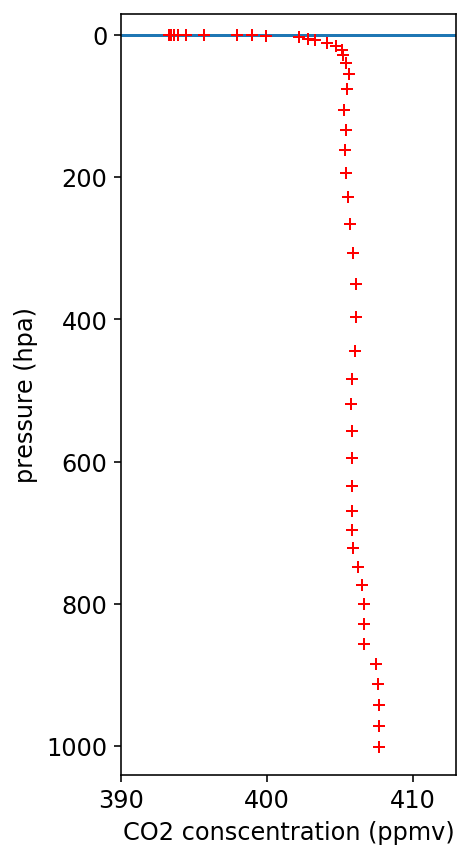

In [9]:
# pick one location where we have data from OCO2 
# and show difference in levels
irecord = 9442
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][47007,:] # 47 levels

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+') # co2 unit is still ppbv here
ax.set_ylim(1040,-30)  # reverse y axis
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hpa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

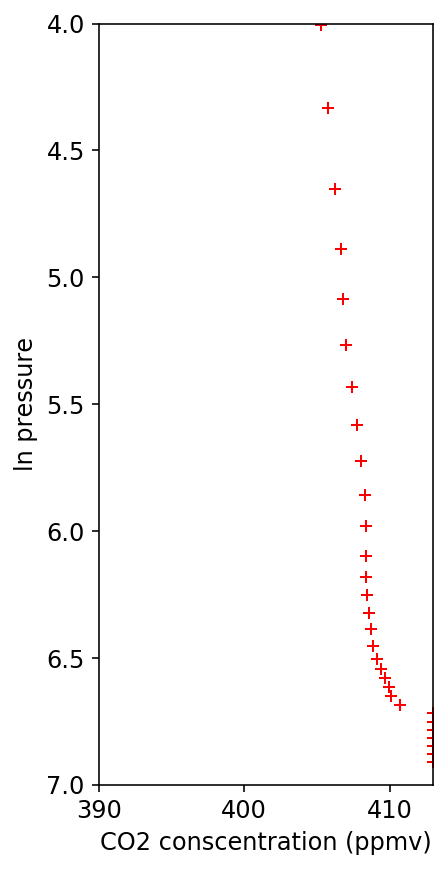

In [10]:
# pick one location where we have data from OCO2
# show in ln pressure coordinate
# linear interpolation using ln(pressure)
# show results of interpolation
y_press_mod = np.log(profile_press_mod[irecord,:].values)
y_press_sat = np.log(profile_press_sat[irecord].values)
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

interpolated_co2 = np.interp(x = y_press_sat, xp = np.flip(y_press_mod), fp = np.flip(x_co2)) # linear inte

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(7,4)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('ln pressure')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

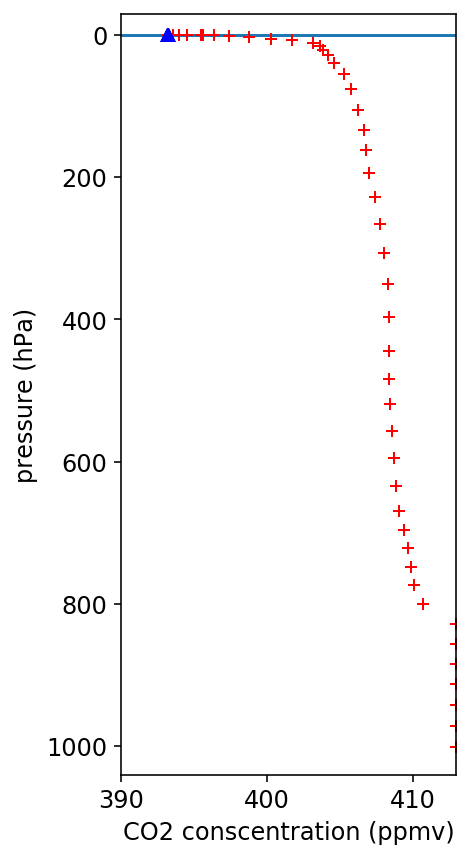

In [11]:
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(1040,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hPa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()
fig.savefig(output_directory + 'interpolation.png', bbox_inches='tight')

In [12]:
# new dataset to store interpolated co2 from model
interpolated = ds_satellite['pressure'].to_dataset()
interpolated

<xarray.Dataset>
Dimensions:   (levels: 20, record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels    (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    pressure  (record, levels) float32 ...

In [13]:
varnames = list(ds_model.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
needed_vars = np.append(varnames[0], varnames[7:29])
needed_vars

array(['SpeciesConc_CO2', 'SpeciesConc_CO2Tag1', 'SpeciesConc_CO2Tag2',
       'SpeciesConc_CO2Tag3', 'SpeciesConc_CO2Tag4',
       'SpeciesConc_CO2Tag5', 'SpeciesConc_CO2Tag6',
       'SpeciesConc_CO2Tag7', 'SpeciesConc_CO2Tag8',
       'SpeciesConc_CO2Tag9', 'SpeciesConc_CO2Tag10',
       'SpeciesConc_CO2Tag11', 'SpeciesConc_CO2Tag12',
       'SpeciesConc_CO2Tag13', 'SpeciesConc_CO2Tag14',
       'SpeciesConc_CO2Tag15', 'SpeciesConc_CO2Tag16',
       'SpeciesConc_CO2Tag17', 'SpeciesConc_CO2Tag18',
       'SpeciesConc_CO2Tag19', 'SpeciesConc_CO2Tag20',
       'SpeciesConc_CO2Tag21', 'SpeciesConc_CO2Tag22'], dtype='<U20')

In [14]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_satellite.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 406224, levels: 20)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0

In [15]:
for ivar in needed_vars:
    interpolated[ivar] = tmp.copy()
interpolated

<xarray.Dataset>
Dimensions:               (levels: 20, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure              (record, levels) float32 ...
    SpeciesConc_CO2       (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag1   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag2   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag3   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag4   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag5   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag6   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag7   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag8   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag9   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag10  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag11  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag12  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag13  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag14  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag15  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag16  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag17  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag18  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag19  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag20  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag21  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag22  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [16]:
# interpolation
for irecord in record:
    if profile_press_sat[irecord][19] != 0.:   # if measurement is non-zero, i.e. exists
        for ivar in needed_vars:
            before         = ds_model[ivar] # get co2 before interpolation
            x_co2          = before[irecord,:].values # a co2 profile
            pres_before    = np.log(profile_press_mod[irecord].values) # log space
            pres_after     = np.log(profile_press_sat[irecord])
            # linear interpolation            
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(x_co2)) 
        print(irecord)

3099
3387
3502
3530
3645
3646
3733
3753
3789
3838
3857
3877
3897
3902
3922
3982
4001
4021
4046
4077
4086
4106
4125
4165
4190
4239
4249
4269
4300
4309
4334
4344
4383
4393
4404
4433
4443
4444
4453
4462
4478
4487
4488
4537
4548
4587
4606
4621
4631
4641
4671
4681
4691
4701
4731
4750
4760
4765
4775
4785
4815
4825
4844
4845
4875
4894
4904
4909
4919
4929
4959
4979
4988
5008
5019
5028
5047
5053
5063
5073
5102
5123
5132
5152
5162
5163
5172
5191
5197
5207
5217
5246
5256
5267
5296
5306
5315
5335
5341
5351
5371
5380
5400
5411
5439
5440
5450
5459
5469
5479
5484
5485
5494
5524
5544
5554
5583
5603
5613
5623
5628
5638
5668
5678
5688
5727
5747
5767
5772
5782
5822
5831
5832
5842
5851
5871
5891
5910
5911
5916
5926
5936
5965
5966
5975
5995
6015
6045
6054
6060
6070
6080
6109
6119
6139
6188
6198
6204
6214
6223
6224
6253
6263
6303
6332
6342
6347
6348
6357
6367
6407
6476
6486
6491
6501
6511
6551
6561
6570
6620
6630
6635
6645
6655
6714
6754
6764
6779
6789
6799
6809
6858
6898
6917
6933
6943
6972
7041
7042
7051


57194
57204
57223
57233
57243
57254
57263
57283
57293
57302
57303
57312
57322
57328
57337
57338
57347
57358
57367
57377
57387
57407
57437
57446
57456
57466
57471
57481
57521
57531
57541
57551
57570
57581
57590
57610
57615
57625
57635
57665
57675
57694
57714
57725
57734
57754
57759
57769
57779
57809
57819
57838
57858
57869
57878
57897
57903
57913
57923
57952
57953
57962
57982
58002
58013
58041
58047
58057
58067
58096
58126
58146
58156
58185
58191
58200
58201
58210
58211
58240
58250
58260
58290
58309
58329
58334
58335
58344
58354
58384
58394
58404
58414
58433
58473
58478
58488
58498
58528
58538
58557
58577
58617
58622
58632
58642
58672
58701
58721
58760
58761
58766
58776
58786
58815
58910
58920
58930
58959
59009
59064
59073
59074
59152
59192
59207
59237
59296
59316
59341
59351
59361
59372
59381
59391
59470
59485
59505
59535
59594
59595
59614
59629
59649
59668
59669
59678
59708
59728
59748
59773
59792
59793
59812
59822
59852
59901
59911
59917
59926
59927
59936
59956
59966
59986
59996
6003

102219
102228
102229
102322
102323
102372
102387
102466
102486
102609
102610
102669
102753
102812
103079
103182
108148
108164
108292
108436
108501
108511
108570
108580
108615
108635
108655
108724
108759
108799
108838
108868
108903
108923
108933
108942
108982
109012
109047
109067
109076
109126
109155
109190
109191
109210
109220
109230
109250
109270
109280
109299
109334
109354
109364
109374
109394
109413
109414
109424
109433
109443
109458
109478
109498
109518
109538
109557
109568
109577
109587
109622
109652
109662
109681
109701
109712
109721
109731
109746
109766
109795
109796
109805
109806
109825
109845
109856
109874
109875
109890
109910
109939
109949
109969
109989
109999
110009
110018
110034
110073
110083
110093
110133
110143
110152
110153
110162
110178
110197
110217
110227
110237
110276
110277
110287
110296
110306
110321
110322
110341
110352
110361
110371
110381
110391
110401
110420
110440
110450
110465
110485
110496
110505
110515
110525
110544
110564
110584
110609
110629
110658
110659

150037
150056
150062
150072
150082
150111
150121
150132
150141
150181
150200
150206
150225
150226
150255
150275
150276
150285
150324
150344
150349
150350
150359
150360
150369
150399
150419
150429
150468
150478
150488
150493
150503
150513
150543
150572
150573
150612
150622
150632
150637
150647
150657
150687
150716
150756
150766
150775
150776
150781
150791
150801
150821
150860
150900
150910
150919
150925
150974
151004
151024
151043
151044
151053
151054
151063
151069
151079
151148
151178
151187
151197
151207
151212
151213
151222
151252
151262
151322
151341
151351
151356
151366
151387
151396
151406
151466
151495
151500
151540
151550
151610
151638
151639
151644
151654
151683
151684
151693
151694
151723
151753
151763
151772
151773
151788
151827
151837
151906
151907
151916
151926
151932
151942
151951
151971
151981
152050
152060
152070
152076
152095
152115
152125
152194
152204
152214
152219
152239
152259
152269
152309
152318
152338
152348
152357
152358
152363
152383
152402
152403
152422
152453

190809
190819
190829
190849
190859
190908
190928
190938
190953
190963
190973
190992
190993
191002
191032
191052
191072
191081
191082
191097
191116
191117
191136
191146
191215
191225
191241
191250
191260
191280
191290
191320
191359
191369
191384
191394
191404
191424
191434
191463
191464
191503
191513
191523
191538
191548
191568
191578
191607
191638
191647
191657
191666
191672
191682
191692
191711
191712
191721
191731
191751
191781
191791
191800
191801
191810
191816
191826
191835
191836
191855
191865
191875
191895
191934
191944
191954
191960
191969
191979
191999
192009
192019
192039
192078
192088
192098
192113
192123
192143
192153
192182
192193
192202
192232
192241
192242
192257
192267
192287
192296
192297
192306
192326
192337
192401
192411
192430
192440
192470
192480
192481
192535
192554
192565
192574
192584
192614
192678
192688
192698
192709
192718
192728
192757
192758
192788
192832
192862
192871
192881
192901
192932
192960
193015
193025
193045
193055
193056
193129
193140
193159
193188

233227
233265
233311
233359
233378
233379
233409
233454
233502
233514
233552
233586
233587
233598
233646
233665
233695
233696
233789
233809
233913
233932
233944
233952
234006
234076
234124
234125
234150
234159
234805
239498
239587
239607
239616
239681
239731
239750
239785
239786
239825
239875
239894
239929
239939
239969
240038
240083
240113
240162
240182
240238
240256
240257
240306
240317
240326
240361
240381
240400
240430
240450
240460
240461
240470
240489
240495
240505
240514
240515
240525
240544
240574
240594
240604
240613
240633
240639
240648
240649
240658
240669
240688
240698
240709
240718
240737
240738
240748
240757
240782
240792
240802
240813
240832
240842
240852
240861
240862
240881
240892
240901
240926
240936
240946
240957
240976
240986
240996
241005
241036
241065
241090
241100
241101
241110
241120
241129
241130
241140
241149
241169
241179
241180
241208
241224
241234
241244
241253
241263
241273
241284
241293
241323
241342
241352
241358
241368
241378
241397
241407
241417
241428

280170
280171
280190
280201
280210
280230
280235
280245
280255
280275
280294
280295
280305
280314
280334
280354
280373
280374
280379
280399
280419
280428
280438
280449
280458
280478
280498
280517
280523
280533
280543
280562
280572
280582
280593
280602
280622
280642
280651
280661
280667
280677
280686
280687
280706
280716
280726
280736
280737
280746
280766
280795
280805
280810
280811
280820
280830
280850
280860
280870
280880
280890
280939
280949
280954
280964
280974
280985
280994
281014
281024
281033
281034
281064
281083
281093
281098
281108
281118
281128
281129
281168
281177
281227
281237
281242
281252
281262
281312
281341
281371
281380
281396
281406
281456
281485
281514
281530
281540
281549
281550
281589
281609
281658
281668
281674
281683
281684
281693
281733
281783
281792
281812
281817
281827
281837
281936
281961
281971
282080
282115
282125
282214
282224
282243
282269
282288
282298
282328
282367
282368
282412
282442
282472
282521
282546
282556
282586
282675
282680
282690
282700
282720

320189
320238
320258
320273
320283
320323
320382
320401
320402
320417
320427
320457
320466
320467
320486
320536
320545
320561
320571
320601
320610
320679
320680
320689
320705
320714
320715
320754
320774
320823
320833
320848
320849
320858
320898
320918
320967
320977
320992
321002
321042
321062
321101
321111
321121
321136
321146
321186
321245
321265
321280
321290
321389
321408
321424
321434
321493
321542
321543
321552
321578
321617
321637
321696
321761
321830
321905
321964
321974
322029
322049
322108
322118
322163
322173
322252
322262
322287
322316
322386
322396
322406
322431
322460
322480
322530
322549
322574
322604
322624
322674
322683
322748
322768
322818
322862
322911
322912
322942
322962
322971
322981
322990
323006
323016
323055
323085
323086
323095
323134
323149
323159
323170
323199
323238
323239
323268
323278
323293
323303
323314
323323
323343
323362
323363
323373
323382
323393
323412
323447
323467
323506
323526
323537
323556
323581
323591
323610
323611
323630
323650
323774
323794

362662
362671
362691
362731
362746
362756
362766
362767
362795
362806
362815
362835
362855
362874
362875
362890
362900
362910
362939
362950
362959
362979
363018
363054
363083
363094
363103
363122
363123
363172
363187
363246
363266
363286
363297
363321
363331
363350
363351
363370
363390
363410
363421
363430
363474
363475
363485
363514
363553
363554
363564
363573
363618
363638
363658
363697
363708
363717
363762
363773
363781
363792
363801
363821
363841
363852
363872
363925
363945
363985
363995
363996
364004
364015
364024
364060
364069
364108
364148
364159
364167
364168
364204
364212
364252
364291
364292
364336
364347
364356
364395
364396
364435
364479
364480
364491
364539
364559
364570
364578
364598
364634
364663
364682
364713
364733
364825
364857
364909
364921
364961
364969
365008
365052
365104
365195
365314
365339
365841
370268
370668
370727
370787
370797
370812
370822
370861
370911
370956
370966
371005
371026
371065
371149
371170
371198
371209
371218
371228
371253
371283
371293
371313

In [17]:
# variables need not to be interpolated
noneed_interp = ['lat', 'lon', 'date']
for ivar in noneed_interp:
    interpolated[ivar] = ds_model[ivar].copy()

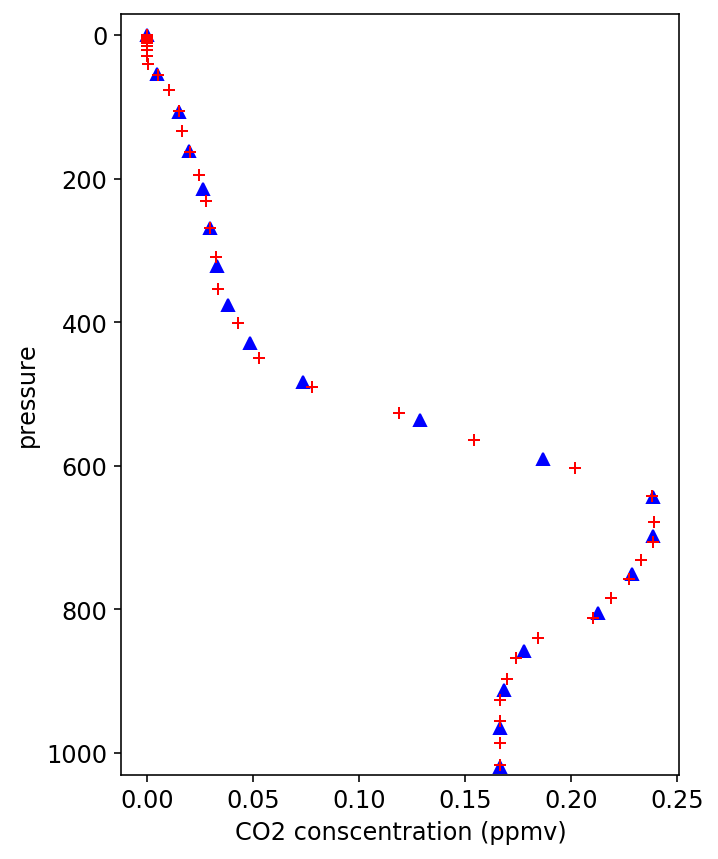

In [25]:
# after interpolation
irecord = 286636
varname = 'SpeciesConc_CO2Tag11'
x_co2_after    = interpolated[varname][irecord,:]
y_press_after  = interpolated['pressure'][irecord,:]

x_co2_before   = ds_model[varname][irecord,:]
y_press_before = profile_press_mod[irecord]

fig, ax = plt.subplots(figsize=[5,7])

ax.plot(x_co2_after*1e-3, y_press_after, 'b^')
ax.plot(x_co2_before*1e-3, y_press_before, 'r+')
ax.set_ylim(1030,-30)
#ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure')

plt.show()

In [19]:
interpolated.attrs['comment'] = 'interpolated from 47 level model outputs'
interpolated.to_netcdf(output_file)

In [20]:
interpolated

<xarray.Dataset>
Dimensions:               (levels: 20, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure              (record, levels) float32 ...
    SpeciesConc_CO2       (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag1   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag2   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag3   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag4   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag5   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag6   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag7   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag8   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag9   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag10  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag11  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag12  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag13  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag14  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag15  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag16  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag17  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag18  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag19  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag20  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag21  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag22  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat                   (record) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (record) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
    date                  (record) datetime64[ns] 2018-05-01 ... 2018-05-31
Attributes:
    comment:  interpolated from 47 level model outputs